In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/imageprocessing')

In [ ]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.1 MB/s eta 0:00:00


In [ ]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import pydicom

plt.set_cmap('gray')
%matplotlib inline

# Seeding
seed = 2019
random.seed(seed)
np.random.seed(seed)

IMG_DTYPE = np.float64
SEG_DTYPE = np.uint8

<Figure size 640x480 with 0 Axes>

In [ ]:
def imshow(*args,**kwargs):
    cmap = kwargs.get('cmap', 'gray')
    title= kwargs.get('title','')
    if len(args)==0:
        raise ValueError("No images given to imshow")
    elif len(args)==1:
        plt.title(title)
        plt.imshow(args[0], interpolation='none')
    else:
        n=len(args)
        if type(cmap)==str:
            cmap = [cmap]*n
        if type(title)==str:
            title= [title]*n
        plt.figure(figsize=(n*5,10))
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.title(title[i])
            plt.imshow(args[i], cmap[i])
    plt.show()

def normalize_image(img):
    """ Normalize image values to [0,1] """
    min_, max_ = float(np.min(img)), float(np.max(img))
    return (img - min_) / (max_ - min_)

In [ ]:
def step1_preprocess_img_slice(img_slc):
    """
    Preprocesses the image 3d volumes by performing the following :
    1- Set pixels with hounsfield value great than 1200, to zero.
    2- Clip all hounsfield values to the range [-100, 400]
    3- Apply Histogram Equalization
    """
    img_slc[img_slc>1200] = 0
    img_slc   = np.clip(img_slc, -100, 400)
    img_slc = normalize_image(img_slc)


    img_slc = img_slc * 255
    img_slc = img_slc.astype('uint8')
    img_slc = cv2.equalizeHist(img_slc)
    img_slc = normalize_image(img_slc)
    return img_slc

In [ ]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __load__(self, id_name):
        patient_id = id_name.split('_')
        image_path = os.path.join(self.path, "patients", id_name)
        mask_path = os.path.join(self.path, "masks")
        all_masks = os.listdir(mask_path)
        dicom_image = pydicom.dcmread(image_path)
        image = step1_preprocess_img_slice(dicom_image.pixel_array)
        image = normalize_image(image)
        image = np.array(Image.fromarray(image).resize([self.image_size, self.image_size])).astype(IMG_DTYPE)

        mask = pydicom.dcmread(os.path.join(mask_path, patient_id[0]+'_liver', id_name)).pixel_array
        mask = mask/255.0
        mask = np.clip(mask, 0, 1)
        mask = np.array(Image.fromarray(mask).resize([self.image_size, self.image_size])).astype(IMG_DTYPE)
        mask = mask[:, :, np.newaxis]
        return image, mask, dicom_image.pixel_array

    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size

        files_batch = self.ids[index*self.batch_size: (index+1)*self.batch_size]

        image = []
        mask = []
        orig=[]

        for id_name in files_batch:
            _img, _mask, _orig = self.__load__(id_name)
            _img = np.stack((_img,)*3, axis=-1)
            image.append(_img)
            mask.append(_mask)
            orig.append(_orig)

        image = np.array(image)
        mask = np.array(mask)
        orig = np.array(orig)

        image = image.astype(IMG_DTYPE)
        mask = mask.astype(SEG_DTYPE)
        orig = orig.astype(IMG_DTYPE)

        return image, mask, orig

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [ ]:
image_size = 256
train_path = "train"
batch_size = 8
epochs = 30

# Training Ids
images = []

for file in os.listdir(os.path.join(train_path, "patients")):
    images.append(file)

# Randomly select 25% of the data
selected_ids = random.sample(images, int(0.25 * len(images)))

# Divide into training and validation sets
val_data_size = len(selected_ids) // 5  # 20% validation Data
valid_ids = selected_ids[:val_data_size]
train_ids = selected_ids[val_data_size:]

print(len(train_ids))

4654


In [ ]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y, orig = gen.__getitem__(2)

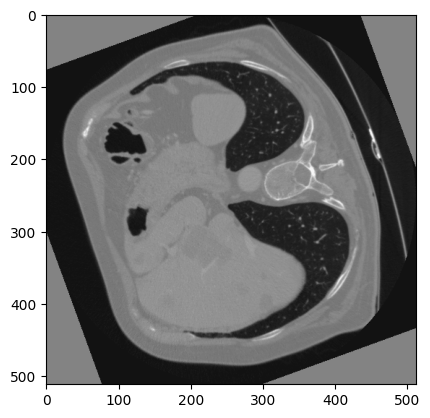

In [ ]:
plt.imshow(orig[1])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_preprocessing(x,y,orig):

  # Randomly select 5 indices
  indices = np.random.choice(len(x), 5, replace=False)

  # Plot 5 sets of 3 images
  for idx in indices:
      plt.figure(figsize=(12, 4))

      # Plot the original image
      plt.subplot(1, 3, 1)
      plt.imshow(orig[idx])
      plt.title('Original CT scan')
      plt.axis('off')

      # Plot the input image (x)
      plt.subplot(1, 3, 2)
      plt.imshow(x[idx])
      plt.title('After preprocessing')
      plt.axis('off')

      # Plot the ground truth (y)
      plt.subplot(1, 3, 3)
      plt.imshow(y[idx])
      plt.title('Ground Truth mask')
      plt.axis('off')

      plt.show()


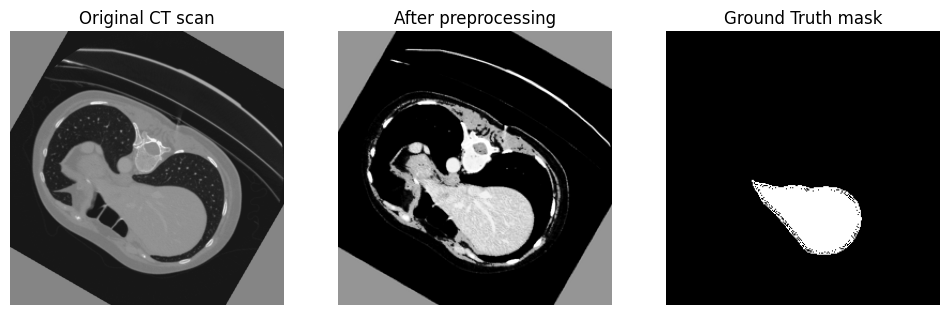

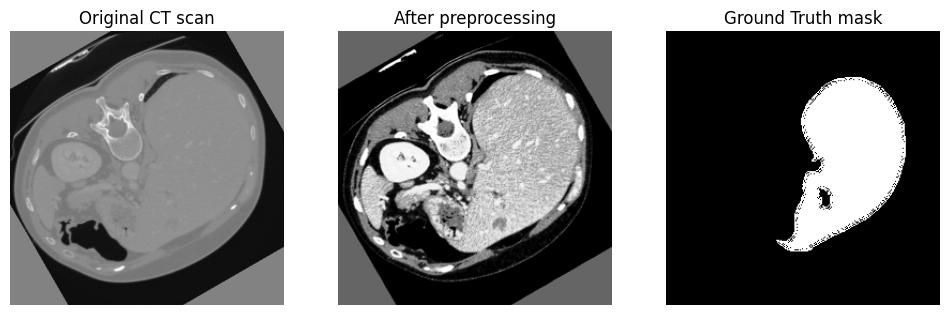

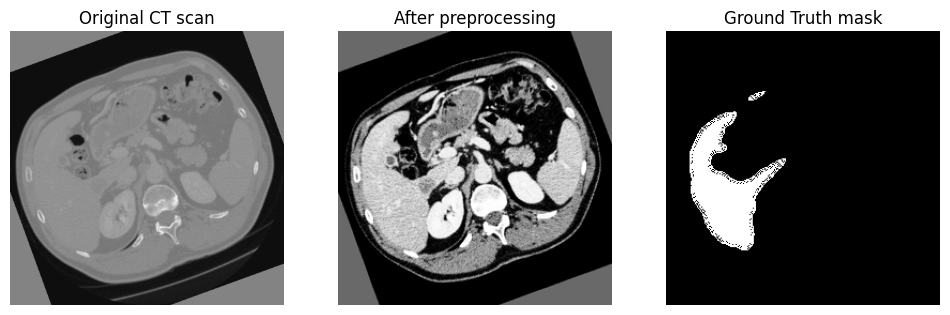

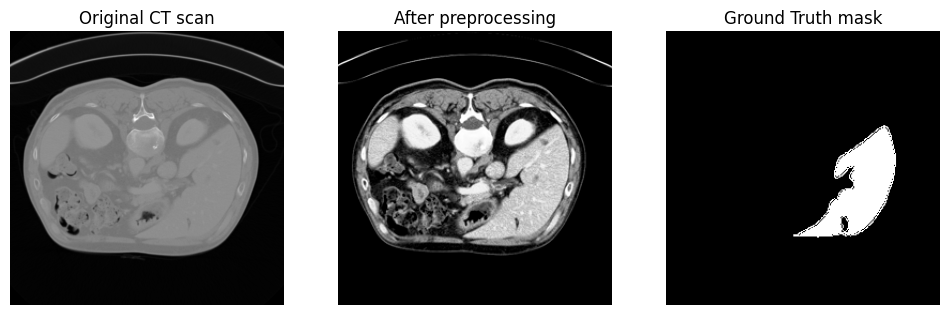

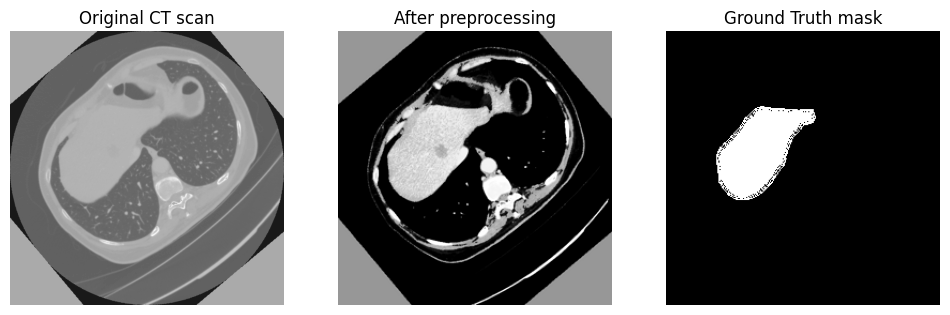

In [ ]:
x, y, orig = gen.__getitem__(1)
show_preprocessing(x,y,orig)

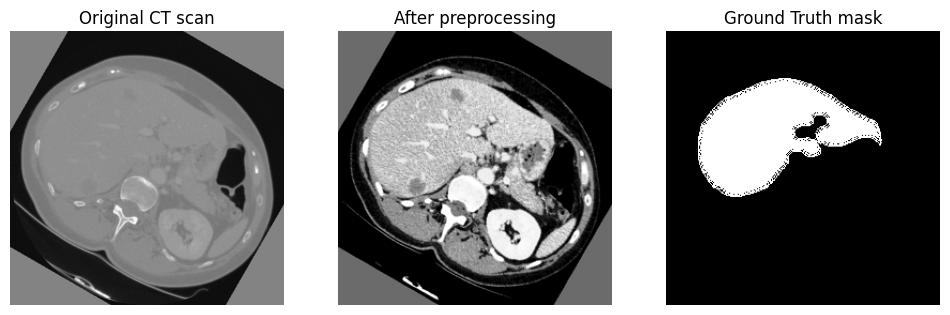

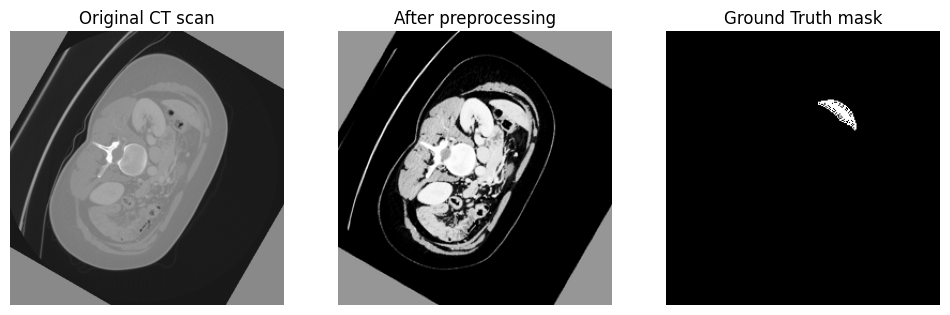

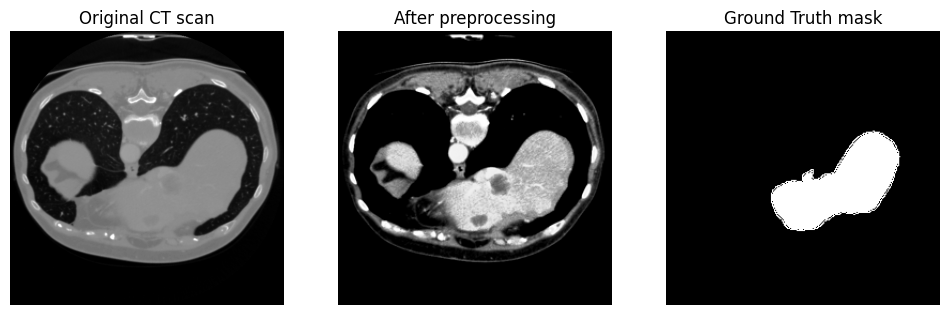

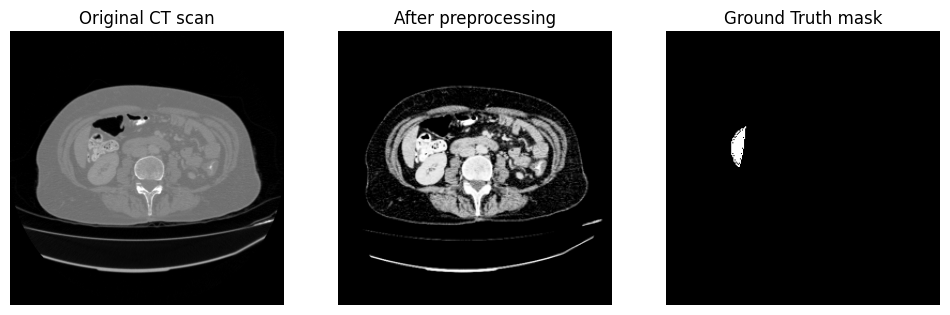

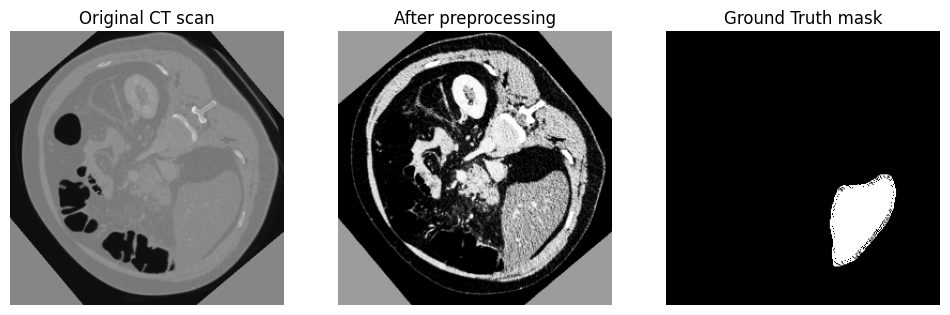

In [ ]:
x, y, orig = gen.__getitem__(5)
show_preprocessing(x,y,orig)

In [6]:
import numpy as np

a = np.array([2,3,1200,1600,400,-100,-300])

a[a>1200] = 0
a

array([   2,    3, 1200,    0,  400, -100, -300])

In [7]:
a   = np.clip(a, -100, 400)
a

array([   2,    3,  400,    0,  400, -100, -100])

In [9]:

def normalize_image(img):
    """ Normalize image values to [0,1] """
    min_, max_ = float(np.min(img)), float(np.max(img))
    return (img - min_) / (max_ - min_)
normalize_image(a)

array([0.204, 0.206, 1.   , 0.2  , 1.   , 0.   , 0.   ])